In [ ]:
!pip install torch
!pip install datashader
!apt-get install libgeos++ libproj-dev
!pip install geoviews

     |████████████████████████████████| 15.5MB 202kB/s 
     |████████████████████████████████| 1.6MB 50.5MB/s 
     |████████████████████████████████| 81kB 13.2MB/s 
     |████████████████████████████████| 675kB 51.6MB/s 
     |████████████████████████████████| 102kB 16.0MB/s 
     |████████████████████████████████| 102kB 16.2MB/s 
  Created wheel for datashape: filename=datashape-0.5.2-cp36-none-any.whl size=59430 sha256=c6054d37de06a3047eb3b3a4cac81c569cbce99ab3a6c75b0856dfa96f2ef664
  Stored in directory: /root/.cache/pip/wheels/8d/06/05/c1cba3d57bdcfd3960e3f60a9fdc97e4baef2ef09af0ad1ef8
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=9ead064e4bee891b1c52888c9b2e0add295f829e3b65e435b5c1e89539f1f543
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4042 sha256=0f1b409192789bf9012abd8e72ebd47c4039764c809ed4df1a2

In [ ]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import math
from google.colab import drive
drive.mount("/content/drive")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Mounted at /content/drive


In [ ]:
userID = 'Jonas' #@param ["Jonas", "Klara", "Sara"]

if 'j' in userID[0].lower():
  working_path = "/content/drive/My Drive/Colab Notebooks/02456-deep-learning-with-PyTorch-master/deep_project/DataLoaderForStudents"
  try:
    os.chdir(f'{working_path}')
  except:
    print('Download and unzip folder')
    !wget https://staticavantipw.s3.eu-west-1.amazonaws.com/DeepLearning2020data/MMM_DataLoaderForStudents.zip
    !unzip '/content/MMM_DataLoaderForStudents.zip' -d '/content/drive/My Drive/Colab Notebooks/02456-deep-learning-with-PyTorch-master/deep_project/DataLoaderForStudents'
    os.chdir(working_path) #Jonas connection
elif 's' in userID[0].lower():
  working_path = "/content/drive/My Drive/Deep Learning/project/DataLoaderForStudents"
  try:
    os.chdir(f'{working_path}')
  except:
    print('Download and unzip folder')
    !wget https://staticavantipw.s3.eu-west-1.amazonaws.com/DeepLearning2020data/MMM_DataLoaderForStudents.zip
    !unzip '/content/MMM_DataLoaderForStudents.zip' -d "/content/drive/My Drive/Deep Learning/project/DataLoaderForStudents"
    os.chdir(working_path) #Sara connection
else:
  working_path = "/content/drive/My Drive/project/DataLoaderForStudents"
  try:
    os.chdir(f'{working_path}')
  except:
    print('Download and unzip folder')
    !wget https://staticavantipw.s3.eu-west-1.amazonaws.com/DeepLearning2020data/MMM_DataLoaderForStudents.zip
    !unzip '/content/MMM_DataLoaderForStudents.zip' -d "/content/drive/My Drive/project/DataLoaderForStudents"
    os.chdir(working_path) #Klara connection

In [ ]:
sys.path.append(f'{working_path}/MMM_DataLoaderForStudents/src')
from data_utils_conda import *
clear_output(wait=False)

In [ ]:
from modelClass2Ch1 import *

In [ ]:
random.seed(123)
user_train, user_val, user_test = train, val, test = train_test_data_split(Random=True)
user_train = [user for user in user_train if user!=4]
user_test = [user for user in user_test if user!=9]
print("We train on users {}\n we validate on users {}\n and we test on users {}".format(user_train,user_val,user_test))

We train on users [0, 1, 6, 10, 11, 8, 3]
 we validate on users [2]
 and we test on users [5, 7]


### Load data set and adjust labels

In [ ]:
# get data
dataset = decompress_pickle(f'{working_path}/MMM_DataLoaderForStudents/Pickle/dataSet.pbz2')
dataset.rename(columns = {"label": "label2"})
labelMeaning = pd.read_csv(f'{working_path}/MMM_DataLoaderForStudents/UID-MMM-labels.csv').drop(columns='Unnamed: 0')[['stop','mode','howTravelled','purpose','mainActivity']]
labelMeaning.head()

,stop,mode,howTravelled,purpose,mainActivity
0,1,0,-100,14,Work
1,2,5,Foot,0,-100
2,1,0,-100,0,-100
3,2,5,Foot,0,-100
4,1,0,-100,14,Work


In [ ]:
# change index to 0/1
dataset.label2 = dataset.label2-1

#### Define class weights due to large class im-balance

In [ ]:
NUM_CLASSES = 2

In [ ]:
data_train = pd.concat([dataset[(dataset.user==tr)] for tr in user_train]).reset_index(drop=True)
data_val = pd.concat([dataset[(dataset.user==va)] for va in user_val]).reset_index(drop=True)
data_test = pd.concat([dataset[(dataset.user==te)] for te in user_test]).reset_index(drop=True)
# The following should be loaded after training phase. You can add the user 4 here, just fot technical limitations. It should be mentioned in the report.
#data_test = pd.concat([dataset[(dataset.user==te)] for te in user_test+[4] if 4 in user_test else user_test]).reset_index(drop=True)

In [ ]:
data_train = data_train[data_train['segment_ix'] >= filter_seq]
data_val = data_val[data_val['segment_ix'] >= filter_seq]
data_test = data_test[data_test['segment_ix'] >= filter_seq]

In [ ]:
# due to class imbalance 
#class_weights = [(data_test[label] == 0).sum()/(data_test[label] == x).sum() for x in range(NUM_CLASSES)]
#class_weights

In [ ]:
image_data = {}
#for user_id in user_test:
for user_id in user_train + user_val + user_test:
  image_data[user_id] = np.stack(decompress_pickle(working_path+f'/MMM_DataLoaderForStudents/Pickle/images_list_{user_id}.pbz2'), axis = 0).astype(float)
  print(image_data[user_id].shape[0])

17990
17990
2344
86277
28845
112
83326
20132
14112
22616


In [ ]:
demo_dataset = ImageTensorDataset(data_test, image_data)

for X_img, X_seq, X_tod, y in torch.utils.data.DataLoader(demo_dataset, batch_size=16, shuffle=True):
    print('X_img :', X_img.shape)
    print(X_img[0, :, :, 0])
    print('X_seq :', X_seq.shape)
    print(X_seq[0, :])
    print('X_tod :', X_tod.shape)
    print(X_tod[0])
    print('y :', y.shape)
    print(y[0])
    break;

print(X_img.shape)
images = (X_img[:,:,:,0]+X_img[:,:,:,1]+X_img[:,:,:,2]+X_img[:,:,:,3]+X_img[:,:,:,9]).reshape(16,9,9,1)
print(images.shape)

X_img : torch.Size([16, 9, 9, 11])
tensor([[0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 0., 1., 0.],
        [0., 0., 1., 1., 1., 1., 0., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 0., 1.],
        [0., 1., 1., 1., 1., 0., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1., 0.],
        [0., 1., 1., 1., 1., 1., 0., 1., 0.],
        [1., 1., 1., 1., 0., 1., 1., 1., 0.]], dtype=torch.float64)
X_seq : torch.Size([16, 6, 2])
tensor([[36.5699, -1.3027],
        [36.0995, -1.3039],
        [35.4268, -1.2980],
        [34.9248, -1.3030],
        [34.6310, -1.3061],
        [34.6517, -1.3037]], dtype=torch.float64)
X_tod : torch.Size([16, 5])
tensor([0., 0., 1., 0., 0.], dtype=torch.float64)
y : torch.Size([16])
tensor(1)
torch.Size([16, 9, 9, 11])
torch.Size([16, 9, 9, 1])


#### Define dataloaders for VAE

In [ ]:
train_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_train, image_data), batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_val, image_data), batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
test_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_test, image_data), batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

### Design VAE

In [ ]:
from torch import nn, Tensor
from torch.distributions import Distribution, Bernoulli
from typing import *

def adjust_lr(optimizer, epoch):
    number_decay_points_passed = np.sum(epoch >= np.array(LEARNING_DECAY_EPOCHS))
    lr = LEARNING_RATE * (LEARNING_DECAY_FACTOR ** number_decay_points_passed)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

class SelectItem(nn.Module):
    def __init__(self, item_index):
        super(SelectItem, self).__init__()
        self._name = 'selectitem'
        self.item_index = item_index

    def forward(self, inputs):
        return inputs[self.item_index]

def conv2d_output_shape(h_w, kernel_size=1, stride=1, padding=0, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * padding) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * padding) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return self.mu + self.sample_epsilon()*self.sigma
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return -((z - self.mu) ** 2) / (2 * self.sigma ** 2) - self.sigma.log() - math.log(math.sqrt(2 * math.pi))


In [ ]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        #self.observation_features = np.prod(input_shape)
        

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`

        # Pipeline [channels, height, width]:
        # CNN: [1, 9, 9] --> [32, 9, 9] --> [32, 4, 4] --> [16, 4, 4] --> [16, 2, 2]
        self.encoder_CNN = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        ) 
        # Pipeline
        # (First: reshape from [channels, height, width] to [channels * height * width])
        # [16, 2, 2] –-> 64 
        # FNN: 64 --> 128
        self.encoder_fnn1 = nn.Sequential(
            nn.Linear(in_features=64, out_features=128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=128, out_features=2*32), # because of 32 latent features
            nn.BatchNorm1d(2*32),
            nn.ReLU(),
            nn.Dropout(0.3)
            #nn.Linear(in_features=64, out_features=2*latent_features)
        )
        #self.encoder_fnn2 = nn.Sequential(
        #    nn.Linear(in_features=self.observation_features, out_features=256),
        #    nn.ReLU(),
        #    nn.Linear(in_features=256, out_features=128),
        #    nn.ReLU(),
        #    nn.Linear(in_features=128, out_features=64),
        #    nn.ReLU(),
        #    # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
        #    nn.Linear(in_features=64, out_features=2*latent_features) # <- note the 2*latent_features
        #)
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder_fnn = nn.Sequential(
            nn.Linear(in_features=32, out_features=128), # in_features = latent_features
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=128, out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )
        #self.decoder = nn.Sequential(
        #    nn.Linear(in_features=latent_features, out_features=128),
        #    nn.ReLU(),
        #    nn.Linear(in_features=128, out_features=256), # added layer
        #    nn.ReLU(), # added activation
        #    nn.Linear(in_features=256, out_features=self.observation_features)
        #)
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(z|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        #print(x.shape)
        x = x.permute(0, 3, 1, 2)
        x_out = self.encoder_CNN(x)
        #print('1: ', x_out.shape)
        x_out = x_out.reshape(x_out.size(0), -1)
        #print('2: ', x_out.shape)
        #x_out = x_out.reshape(64)
        #print('3: ', x_out.shape)
        x_out = self.encoder_fnn1(x_out)
        mu, log_sigma =  x_out.chunk(2, dim=-1)
        
        # return a distribution `q(z|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        #px_logits = self.decoder(z)
        #print(shape(z))
        #x.view(z.shape)
        x = self.decoder_fnn(z)
        x = x.reshape(-1, 16, 2, 2) # reshape to fit output of self.encoder() and input of decoder
        # interpolate from [16, 2, 2] --> [16, 4, 4] (inverse maxpooling ish)
        x = nn.functional.interpolate(x, size=[4,4], mode='bilinear', align_corners=False)
        x = self.decoder1(x)
        # interpolate from [16, 4, 4] --> [16, 9, 9] (inverse maxpooling ish)
        x = nn.functional.interpolate(x, size=[9,9], mode='bilinear', align_corners=False)
        px_logits = self.decoder2(x)

        px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
        return Bernoulli(logits=px_logits)
        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        #x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}

latent_features = 32
print(images[0].reshape(1,9,9,1).shape)
vae = VariationalAutoencoder(images[0].reshape(1,9,9,1).shape, latent_features).cuda()
print(vae)

torch.Size([1, 9, 9, 1])
VariationalAutoencoder(
  (encoder_CNN): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_fnn1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (

In [ ]:
#vae = VariationalAutoencoder([1,9,9,1], latent_features=latent_features).cuda()
vae.load_state_dict(torch.load(os.getcwd()+"/trained_vae_label2_ch1_vol3"))
vae.eval()

VariationalAutoencoder(
  (encoder_CNN): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_fnn1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropo

#### Test input/output of VAE

In [ ]:
#images1 = X_img
#print(images1.shape)
#images1 = images1[:,:,:,1]
print(X_img.shape)
images = (X_img[:,:,:,0]+X_img[:,:,:,1]+X_img[:,:,:,2]+X_img[:,:,:,3]+X_img[:,:,:,9]).reshape(16,9,9,1)
print(images.shape)

#images = torch.empty([10,81])
#print(images.shape)
#for i, x in enumerate(images1):
#  print(x.shape)
#  images[i] = x.view(9**2)

outputs = vae(images.float().cuda())

torch.Size([16, 9, 9, 11])
torch.Size([16, 9, 9, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


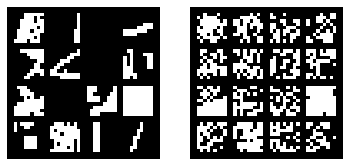

In [ ]:
from torchvision.utils import make_grid
def plot_samples(ax, x):
    x = x.to('cpu')
    nrow = int(np.sqrt(x.size(0)))
    x_grid = make_grid(x.view(-1, 1, 9, 9), nrow=nrow).permute(1, 2, 0)
    ax.imshow(x_grid)
    ax.axis('off')

# plot the observations and samples from posterior
fig, axes = plt.subplots(1, 2)
plot_samples(axes[0], images)

px = outputs['px']
x_sample = px.sample().to('cpu')
plot_samples(axes[1], x_sample)

In [ ]:
# plot of image sequence and the reconstruction noise
demo_dataset2 = ImageTensorDataset(data_val, image_data)

for demo_X_img, demo_X_seq, demo_X_tod, demo_y in torch.utils.data.DataLoader(demo_dataset2, batch_size=16, shuffle=False):
    #print('X_img :', demo_X_img.shape)
    #print(demo_X_img[0, :, :, 0])
    #print('X_seq :', demo_X_seq.shape)
    #print(demo_X_seq[0, :])
    #print('X_tod :', demo_X_tod.shape)
    #print(demo_X_tod[0])
    #print('y :', demo_y.shape)
    #print(demo_y[0])
    print('loaded demo')
    break;

print(demo_X_img.shape)
demo_images = (demo_X_img[:,:,:,0]+demo_X_img[:,:,:,1]+demo_X_img[:,:,:,2]+demo_X_img[:,:,:,3]+demo_X_img[:,:,:,9]).reshape(16,9,9,1)
print(demo_images.shape)
demo_outputs = vae(demo_images.float().cuda())

loaded demo
torch.Size([16, 9, 9, 11])
torch.Size([16, 9, 9, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


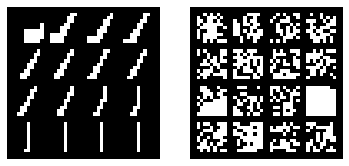

In [ ]:
# plot the observations and samples from posterior
fig, axes = plt.subplots(1, 2)
plot_samples(axes[0], demo_images)

demo_px = outputs['px']
demo_x_sample = demo_px.sample().to('cpu')
plot_samples(axes[1], demo_x_sample)

### Reconstruct data

In [ ]:
phases = {
    'train': {
        'dataloader': train_dataloader,
        'is_training': True,
    },
    'validation': {
        'dataloader': val_dataloader,
        'is_training': False,
    },
    'test': {
        'dataloader': test_dataloader,
        'is_training': False,
    }
}

#### Class weigths

In [ ]:
class_weights = [(data_train[label] == 0).sum()/(data_train[label] == x).sum() for x in range(NUM_CLASSES)]
#class_weights[-2:] = [np.max(class_weights[:-2]), np.max(class_weights[:-2])]
class_weights

[1.0, 3.0267842886795466]

#### Define model, optimizer and loss

In [ ]:
model = CnnNet().cuda()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-10)
criterion = nn.CrossEntropyLoss(weight = torch.Tensor(class_weights).cuda())

#### Test input/output of model

In [ ]:
out = model(images.float().cuda()#.to(device, dtype=torch.float)
, X_seq.float().cuda()#.to(device, dtype=torch.float)
, X_tod.float().cuda()#.to(device, dtype=torch.float)
)
print(out.shape)

torch.Size([16, 2])


#### Train/Validation loop

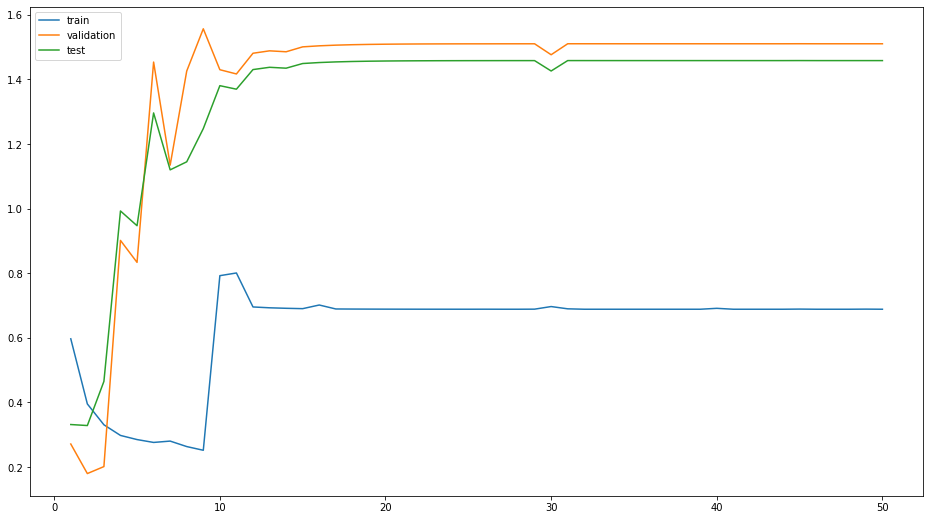

average epoch duration 16.384999475479127
stdev epoch duration 0.6485485453245735
Training lasted 819.2499737739563


In [ ]:
#CUDA_LAUNCH_BLOCKING=1 
epochComputationTime =  []
for epoch in range(1, NUM_EPOCH + 1):
    
    for phase_name, phase in phases.items():
        epoach_loss = 0.0
                
        phase_is_training = phase['is_training']
        phase_dataloader = phase['dataloader']
        model.train(phase_is_training)
        
        # Ajust and save the learning rate in the phase dict
        if phase_is_training:
            startEpoch = time.time()
            lr = adjust_lr(optimizer, epoch)
            phase.setdefault('lr', []).append(lr)
            
        # Iterate over each bath in the phase
        for i, batch in enumerate(phase_dataloader, 1):
            #print(i)
            #print(batch[0].shape)
            X_img0, X_seq, X_tod, y = batch 
            X_img = (X_img0[:,:,:,0]+X_img0[:,:,:,1]+X_img0[:,:,:,2]+X_img0[:,:,:,3]+X_img0[:,:,:,9]).reshape(X_img0.size()[0],9,9,1)
            #print(X_img.size(),X_seq.shape,X_tod.shape)

            X_img = X_img.float().cuda()#.to(device, dtype=torch.float)
            X_seq = X_seq.float().cuda()#.to(device, dtype=torch.float)
            X_tod = X_tod.float().cuda()#.to(device, dtype=torch.float)
            y = y.long().cuda()#.to(device, dtype=torch.int64)

            with torch.set_grad_enabled(phase_is_training):
                outputs = vae(X_img)
                px = outputs['px']
                X_img_wrong_shape = px.sample()
                X_img_recons1 = torch.empty([X_img.shape[0],9,9,1])
                for j,x_rec in enumerate(X_img_wrong_shape): 
                    X_img_recons1[j] = x_rec.view(9,9,1)
                X_img_recons = X_img_recons1.float().cuda()
                out = model(X_img_recons, X_seq, X_tod)
                loss = criterion(out, y)

            if phase_is_training:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(model.parameters(), 0.4)
                optimizer.step()
        
            epoach_loss += loss.item()
        
        # Save the loss for the epoch in the phase dict
        phase.setdefault('loss', []).append(epoach_loss/i)
        if phase_is_training:
            endEpoch = time.time()
            epochComputationTime.append(endEpoch-startEpoch)
            
        
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize = (16, 9))
    #ax.set_yscale('log')
    
    for phase_name, phase in phases.items():
        ax.plot(np.arange(1, epoch + 1), phase['loss'], label = phase_name)        
    
    ax.legend()
    plt.show();
    print(f'average epoch duration {np.mean(epochComputationTime)}')
    print(f'stdev epoch duration {np.std(epochComputationTime)}')
    print(f'Training lasted {np.sum(epochComputationTime)}')

In [ ]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    phase_dataloader = phase['dataloader']
    phase['predicted'] = []
    phase['true'] = []
    
    for i, batch in enumerate(phase_dataloader, 1):
        X_img0, X_seq, X_tod, y = batch
        X_img = (X_img0[:,:,:,0]+X_img0[:,:,:,1]+X_img0[:,:,:,2]+X_img0[:,:,:,3]+X_img0[:,:,:,9]).reshape(X_img0.size()[0],9,9,1)

        phase['true'].extend(list(y.numpy()))
        
        X_img = X_img.float().cuda()#.to(device, dtype=torch.float)
        X_seq = X_seq.float().cuda()#.to(device, dtype=torch.float)
        X_tod = X_tod.float().cuda()#.to(device, dtype=torch.float)
        y = y.float().cuda()#.to(device, dtype=torch.float)
        
        with torch.no_grad():
            outputs = vae(X_img)
            px = outputs['px']
            X_img_wrong_shape = px.sample()
            X_img_recons1 = torch.empty([X_img.shape[0],9,9,1])
            for j,x_rec in enumerate(X_img_wrong_shape): 
                X_img_recons1[j] = x_rec.view(9,9,1)
            X_img_recons = X_img_recons1.float().cuda()
            out = model(X_img_recons, X_seq, X_tod)
            probability, predicted = torch.max(out, 1)
            
        phase['predicted'].extend(list(predicted.cpu().numpy())) 

In [ ]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    print(phase_name)
    print(classification_report(phase['true'], phase['predicted'], target_names = ['stop','motion']))

validation
              precision    recall  f1-score   support

        stop       0.11      1.00      0.19      1503
      motion       0.00      0.00      0.00     12744

    accuracy                           0.11     14247
   macro avg       0.05      0.50      0.10     14247
weighted avg       0.01      0.11      0.02     14247

test
              precision    recall  f1-score   support

        stop       0.18      1.00      0.31      3778
      motion       0.00      0.00      0.00     17112

    accuracy                           0.18     20890
   macro avg       0.09      0.50      0.15     20890
weighted avg       0.03      0.18      0.06     20890



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
sum(p.numel() for p in model.parameters())

99784

In [ ]:
confusion_matrix(phase['true'],phase['predicted'])

array([[ 3778,     0],
       [17112,     0]])

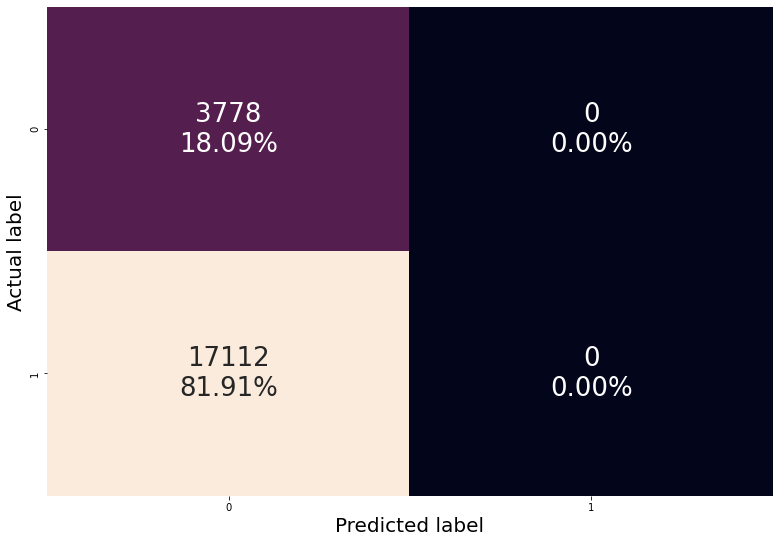

In [ ]:
df_cm = confusion_matrix(phase['true'],phase['predicted'])
#df_cm = pd.DataFrame(df_cm, range(2), range(2))

group_counts = ["{0:0.0f}".format(value) for value in df_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in df_cm.flatten()/np.sum(df_cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(13,9))
sns.heatmap(df_cm, annot=labels, annot_kws={"size": 26}, fmt='', cbar=False) # counts and percentage of total
#sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.0f', cbar=False) # counts
#sns.heatmap(df_cm/df_cm.sum(), annot=True, annot_kws={"size": 16}, fmt='.2%', cbar=False) # precision
#sns.heatmap(df_cm.div(df_cm.sum(axis=1), axis=0), annot=True, annot_kws={"size": 16}, fmt='.2%', cbar=False,
#            xticklabels=['0','1'], yticklabels=['0','1']) # recall
plt.xlabel('Predicted label',fontsize=20)
plt.ylabel('Actual label',fontsize=20)
#plt.title('Confusion matrix, with recall scores')
plt.show()

In [ ]:
train_stop = data_train[data_train['label2']==0]['user'].count()
train_motion = data_train[data_train['label2']==1]['user'].count()
train_sum = train_stop+train_motion
train_stop = (train_stop/train_sum*100)
train_motion = train_motion/train_sum*100

val_stop = data_val[data_val['label2']==0]['user'].count()
val_motion = data_val[data_val['label2']==1]['user'].count()
val_sum = val_stop+val_motion
val_stop = val_stop/val_sum*100
val_motion = val_motion/val_sum*100

test_stop = data_test[data_test['label2']==0]['user'].count()
test_motion = data_test[data_test['label2']==1]['user'].count()
test_sum = test_stop+test_motion
test_stop = test_stop/test_sum*100
test_motion = test_motion/test_sum*100

print('Stop & {}\% & {}\% & {}\%\\\\ \n Motion & {}\% & {}\% & {}\%'.format(train_stop,val_stop,test_stop,train_motion,val_motion,test_motion))

Stop & 75.16628832561783\% & 10.549589387239418\% & 18.085208233604597\%\\ 
 Motion & 24.83371167438218\% & 89.45041061276058\% & 81.9147917663954\%
